[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 1000
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[INFO] Start Scenario Index: 42, Num Scenarios : 1


Episode 0/1000, Reward: 5.45, Length: 107, Epsilon: 1.0000, Eval Reward: -26.49
Episode 50/1000, Reward: 51.28, Length: 116, Epsilon: 0.7899, Eval Reward: -38.62
Episode 100/1000, Reward: 29.90, Length: 123, Epsilon: 0.6262, Eval Reward: -33.11
Episode 150/1000, Reward: 1.78, Length: 112, Epsilon: 0.4987, Eval Reward: -40.35
Episode 200/1000, Reward: -33.13, Length: 53, Epsilon: 0.3995, Eval Reward: -32.29
Episode 250/1000, Reward: -44.69, Length: 28, Epsilon: 0.3222, Eval Reward: -26.16
Episode 300/1000, Reward: -31.87, Length: 57, Epsilon: 0.2620, Eval Reward: -10.64
Episode 350/1000, Reward: -31.23, Length: 53, Epsilon: 0.2151, Eval Reward: -30.76
Episode 400/1000, Reward: -41.62, Length: 40, Epsilon: 0.1786, Eval Reward: 17.76
Episode 450/1000, Reward: -20.45, Length: 59, Epsilon: 0.1501, Eval Reward: -22.63
Episode 500/1000, Reward: 20.30, Length: 114, Epsilon: 0.1280, Eval Reward: 42.41
Episode 550/1000, Reward: -29.56, Length: 58, Epsilon: 0.1107, Eval Reward: 61.58
Episode 600/

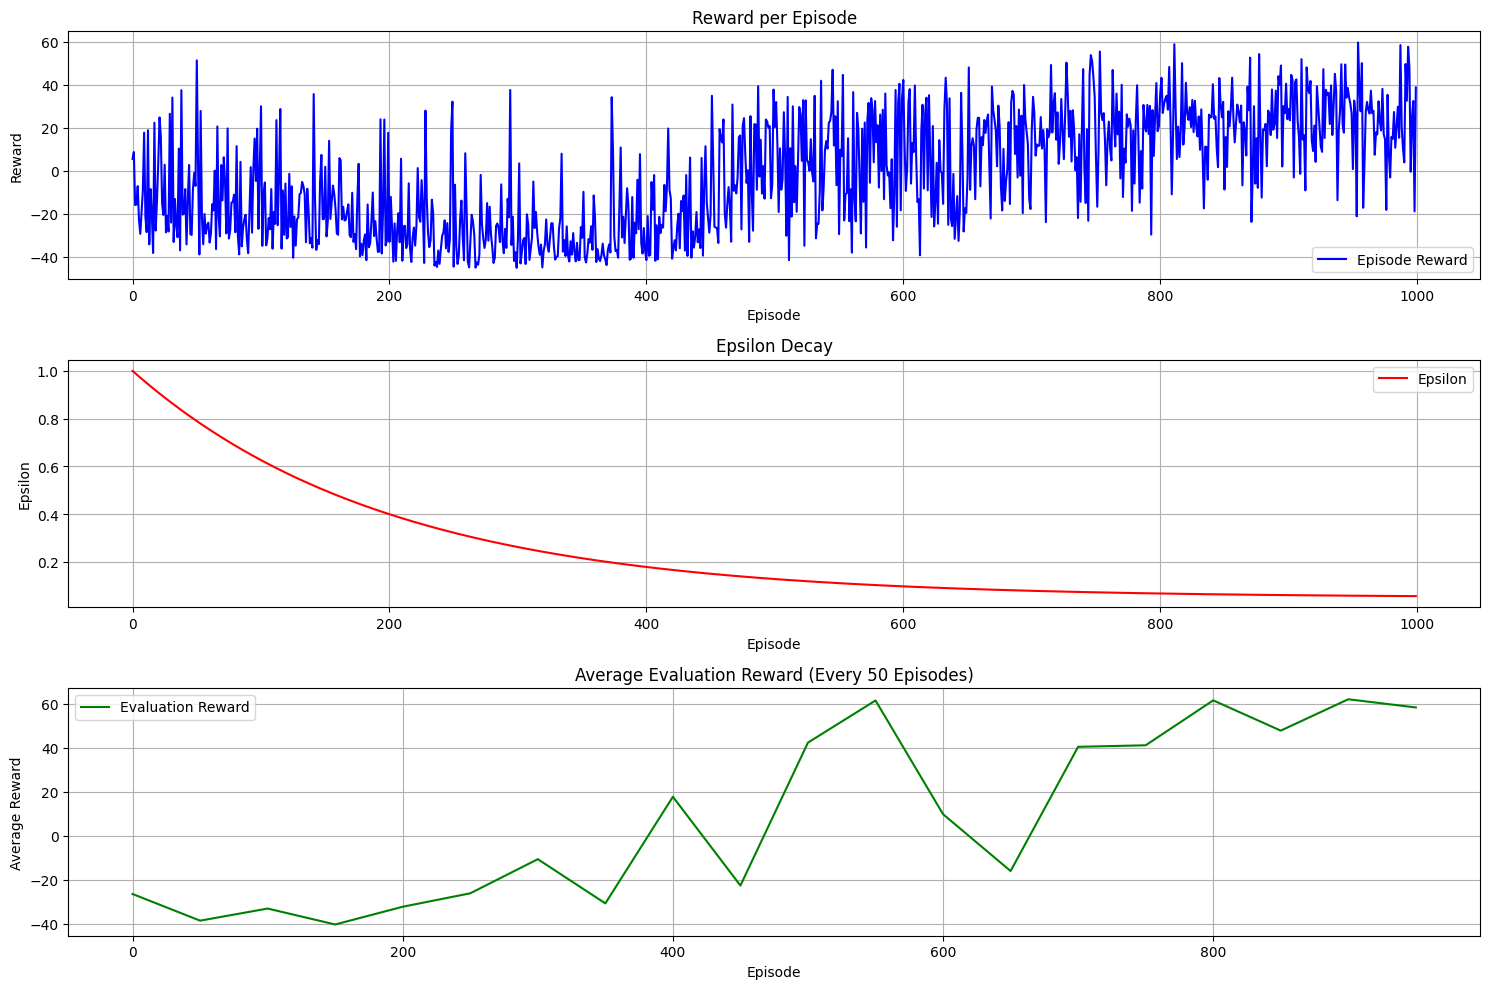

In [ ]:
import gymnasium as gym
import torch
import numpy as np
import random
import os
import time
from collections import deque
from torch import nn, optim
import torch.nn.functional as F
from metadrive.envs import MetaDriveEnv
from metadrive.engine.engine_utils import close_engine
from metadrive.component.sensors.lidar import Lidar
import matplotlib.pyplot as plt

# [Previous classes remain unchanged: SeedWrapper, DiscreteActionWrapper, EnhancedObservationWrapper, 
# FrameStackWrapper, ReplayBuffer, EnhancedDuelingDDQN, LinearLRScheduler]

class SeedWrapper(gym.Wrapper):
    def __init__(self, env, fixed_seed=42):
        super().__init__(env)
        self.fixed_seed = fixed_seed
        np.random.seed(self.fixed_seed)
        random.seed(self.fixed_seed)

    def reset(self, seed=None, options=None, **kwargs):
        kwargs['seed'] = self.fixed_seed
        return self.env.reset(**kwargs)

class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.discrete_actions = [
            np.array([0.0, 1.0, 0.0]),     
            np.array([0.0, 0.0, 0.0]),     
            np.array([-0.5, 1.0, 0.0]),    
            np.array([0.5, 1.0, 0.0]),     
            np.array([0.0, 0.0, 1.0]),     
            np.array([-0.2, 0.5, 0.0]),    
            np.array([0.2, 0.5, 0.0]),     
            np.array([0.0, 0.5, 0.0]),     
            np.array([-0.05, 0.8, 0.0]),   
            np.array([0.05, 0.8, 0.0]),    
            np.array([-0.3, 0.8, 0.0]),    
            np.array([0.3, 0.8, 0.0]),     
            np.array([-0.2, 0.3, 0.0]),    
            np.array([0.2, 0.3, 0.0]),     
            np.array([-0.1, 1.0, 0.0]),    
            np.array([0.1, 1.0, 0.0]),     
            np.array([-0.025, 0.8, 0.0]),  
            np.array([0.025, 0.8, 0.0])    
        ]
        self.action_space = gym.spaces.Discrete(len(self.discrete_actions))

    def action(self, action_idx):
        return self.discrete_actions[action_idx]

    def reset(self, **kwargs):
        kwargs.pop("options", None)
        return self.env.reset(**kwargs)

class EnhancedObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, lidar_points=240):
        super().__init__(env)
        self.lidar_points = lidar_points
        self.observation_space = gym.spaces.Box(
            low=-float('inf'), 
            high=float('inf'), 
            shape=(lidar_points + 10,),
            dtype=np.float32
        )

    def observation(self, obs):
        base_env = self.env.unwrapped
        vehicle = base_env.agents.get("agent0")
        lidar_obs = np.clip(obs[:self.lidar_points], 0.0, 50.0).astype(np.float32)
        lane_features = np.zeros(10, dtype=np.float32)
        
        if vehicle and vehicle.lane and vehicle.navigation:
            try:
                if vehicle.lane in vehicle.navigation.current_ref_lanes:
                    current_lane = vehicle.lane
                else:
                    current_lane = vehicle.navigation.current_ref_lanes[0]
                
                _, lateral_dist = current_lane.local_coordinates(vehicle.position)
                lane_width = vehicle.navigation.get_current_lane_width()
                normalized_lateral = lateral_dist / (lane_width/2)
                lane_heading = current_lane.heading_at(vehicle.position)
                heading_diff = np.abs(np.mod(vehicle.heading_theta - lane_heading, 2 * np.pi))
                heading_diff = min(heading_diff, 2 * np.pi - heading_diff) / np.pi
                dist_to_intersection = 50.0
                if hasattr(vehicle.navigation, 'next_intersection_distance'):
                    dist_to_intersection = vehicle.navigation.next_intersection_distance()
                target_lane_index = vehicle.navigation.next_target_lane_index
                suggested_steering = 0.0
                if target_lane_index is not None and target_lane_index != vehicle.lane_index:
                    suggested_steering = 1.0 if target_lane_index > vehicle.lane_index else -1.0
                speed_norm = vehicle.speed_km_h / vehicle.max_speed_km_h
                
                intersection_approach = 1.0 - min(dist_to_intersection / 20.0, 1.0)
                target_heading_diff = 0.0
                if vehicle.navigation.is_in_intersection() and hasattr(vehicle.navigation, 'next_target_lane'):
                    next_lane = vehicle.navigation.next_target_lane
                    if next_lane:
                        target_heading = next_lane.heading_at(next_lane.start)
                        target_heading_diff = np.abs(np.mod(vehicle.heading_theta - target_heading, 2 * np.pi))
                        target_heading_diff = min(target_heading_diff, 2 * np.pi - target_heading_diff) / np.pi
                
                lane_features[0] = normalized_lateral
                lane_features[1] = heading_diff
                lane_features[2] = min(1.0, dist_to_intersection / 50.0)
                lane_features[3] = suggested_steering
                lane_features[4] = speed_norm
                lane_features[5] = 1.0 if vehicle.navigation.is_in_intersection() else 0.0
                lane_features[6] = vehicle.steering / vehicle.max_steering
                lane_features[7] = 1.0 if vehicle.navigation.is_on_straight_road() else 0.0
                lane_features[8] = intersection_approach
                lane_features[9] = target_heading_diff
            except:
                pass
        
        combined_obs = np.concatenate([lidar_obs, lane_features])
        return combined_obs

class FrameStackWrapper(gym.Wrapper):
    def __init__(self, env, num_stack=3):
        super().__init__(env)
        self.num_stack = num_stack
        self.frames = deque(maxlen=num_stack)
        obs_shape = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=np.repeat(env.observation_space.low[np.newaxis, ...], num_stack, axis=0).flatten(),
            high=np.repeat(env.observation_space.high[np.newaxis, ...], num_stack, axis=0).flatten(),
            shape=(obs_shape[0] * num_stack,),
            dtype=env.observation_space.dtype
        )

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.num_stack):
            self.frames.append(obs)
        return self._get_observation(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_observation(), reward, terminated, truncated, info

    def _get_observation(self):
        return np.concatenate(list(self.frames))

class ReplayBuffer:
    def __init__(self, capacity=100000, alpha=0.6, beta=0.4, beta_increment=1e-5):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.size = 0
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        max_priority = self.max_priority if self.size > 0 else 1.0
        if self.size < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities[self.position] = max_priority
            self.size += 1
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        self.beta = min(1.0, self.beta + self.beta_increment)
        if self.size < batch_size:
            batch = random.sample(list(self.buffer), self.size)
            indices = np.random.choice(self.size, self.size, replace=False)
        else:
            priorities = self.priorities[:self.size] ** self.alpha
            probabilities = priorities / np.sum(priorities)
            indices = np.random.choice(self.size, batch_size, replace=False, p=probabilities)
            batch = [self.buffer[i] for i in indices]
        weights = (self.size * probabilities[indices]) ** (-self.beta)
        weights /= np.max(weights)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.stack(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.stack(next_states),
            np.array(dones, dtype=np.float32),
            indices,
            np.array(weights, dtype=np.float32)
        )

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return self.size

class EnhancedDuelingDDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedDuelingDDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

def select_action(state, epsilon, policy_net, action_dim, device):
    if np.random.rand() < epsilon:
        return random.randint(0, action_dim - 1)
    with torch.no_grad():
        policy_net.eval()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = policy_net(state_tensor).argmax().item()
        policy_net.train()
        return action

def compute_enhanced_reward(vehicle, config):
    reward = 0.0
    if vehicle.lane and vehicle.navigation:
        if vehicle.lane in vehicle.navigation.current_ref_lanes:
            current_lane = vehicle.lane
            positive_road = 1
        else:
            current_lane = vehicle.navigation.current_ref_lanes[0]
            current_road = vehicle.navigation.current_road
            positive_road = 1 if not current_road.is_negative_road() else -1
        
        long_last, _ = current_lane.local_coordinates(vehicle.last_position)
        long_now, lateral_now = current_lane.local_coordinates(vehicle.position)
        lane_width = vehicle.navigation.get_current_lane_width()
        normalized_lateral = abs(lateral_now) / (lane_width/2)
        lateral_factor = max(1 - normalized_lateral**3, 0.0)
        forward_progress = long_now - long_last
        driving_reward = config["driving_reward"] * forward_progress * lateral_factor * positive_road
        reward += driving_reward * 2.5
        speed_factor = min(vehicle.speed_km_h / (0.7 * vehicle.max_speed_km_h), 1.0)
        in_intersection = vehicle.navigation.is_in_intersection()
        if in_intersection:
            speed_factor *= 0.5
        speed_reward = config["speed_reward"] * speed_factor * positive_road
        reward += speed_reward
        
        lane_deviation_penalty = -3.0 * normalized_lateral**2
        reward += lane_deviation_penalty
        
        try:
            ref_heading = current_lane.heading_at(vehicle.position)
            heading_diff = np.abs(np.mod(vehicle.heading_theta - ref_heading, 2 * np.pi))
            heading_diff = min(heading_diff, 2 * np.pi - heading_diff) / np.pi
            heading_multiplier = 5.0 if in_intersection else 3.0
            heading_reward = -heading_multiplier * heading_diff**2
            reward += heading_reward
        except:
            pass
        
        try:
            steering = abs(vehicle.current_action[0]) if hasattr(vehicle, 'current_action') and vehicle.current_action is not None else 0
            speed_multiplier = max(1.0, vehicle.speed_km_h / 40.0)
            steering_penalty = -2.0 * steering**2 * speed_multiplier
            reward += steering_penalty
        except:
            pass
        
        try:
            if hasattr(vehicle, 'last_lateral_pos'):
                lateral_change = abs(lateral_now - vehicle.last_lateral_pos)
                consistency_reward = 1.0 * (1.0 - min(lateral_change / (lane_width/4), 1.0))
                reward += consistency_reward
            vehicle.last_lateral_pos = lateral_now
        except:
            vehicle.last_lateral_pos = lateral_now
        
        try:
            if in_intersection:
                target_heading = None
                if hasattr(vehicle.navigation, 'next_target_lane'):
                    next_lane = vehicle.navigation.next_target_lane
                    if next_lane:
                        target_heading = next_lane.heading_at(next_lane.start)
                if target_heading is not None:
                    turn_heading_diff = np.abs(np.mod(vehicle.heading_theta - target_heading, 2 * np.pi))
                    turn_heading_diff = min(turn_heading_diff, 2 * np.pi - turn_heading_diff) / np.pi
                    turn_reward = 3.0 * (1.0 - turn_heading_diff)
                    reward += turn_reward
        except:
            pass
        
        try:
            if hasattr(vehicle.navigation, 'future_path'):
                future_points = vehicle.navigation.future_path(lookahead=5)
                if future_points and len(future_points) > 1:
                    future_alignment = 0
                    for i, point in enumerate(future_points[1:], 1):
                        vec_to_point = np.array([point[0] - vehicle.position[0], point[1] - vehicle.position[1]])
                        if np.linalg.norm(vec_to_point) > 0:
                            vec_to_point = vec_to_point / np.linalg.norm(vec_to_point)
                            vehicle_heading_vec = np.array([np.cos(vehicle.heading_theta), np.sin(vehicle.heading_theta)])
                            alignment = np.dot(vec_to_point, vehicle_heading_vec)
                            future_alignment += alignment * (1.0 / i)
                    future_path_reward = future_alignment / len(future_points[1:])
                    reward += future_path_reward * 3.0
        except:
            pass
    
    if vehicle.arrive_destination:
        reward += config["success_reward"]
    if vehicle.out_of_road:
        reward -= config["out_of_road_penalty"]
    if vehicle.crash_vehicle:
        reward -= config["crash_vehicle_penalty"]
    if vehicle.crash_object:
        reward -= config["crash_object_penalty"]
        
    return reward

class LinearLRScheduler:
    def __init__(self, optimizer, start_lr, end_lr, decay_steps):
        self.optimizer = optimizer
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.decay_steps = decay_steps
        self.current_step = 0
        
    def step(self):
        self.current_step += 1
        progress = min(1.0, self.current_step / self.decay_steps)
        lr = self.start_lr + progress * (self.end_lr - self.start_lr)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

def train_ddqn(env, policy_net, target_net, optimizer, buffer, num_episodes, 
               batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay, 
               target_update_freq, lr_scheduler, device="cpu"):
    
    episode_rewards = []
    episode_lengths = []
    evaluation_scores = []
    epsilons = []
    
    os.makedirs("models", exist_ok=True)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)
        epsilons.append(epsilon)
        
        while not done:
            action = select_action(state, epsilon, policy_net, env.action_space.n, device)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            vehicle = env.unwrapped.agents.get("agent0")
            if vehicle:
                reward = compute_enhanced_reward(vehicle, env.unwrapped.config)
            
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            episode_length += 1
            
            if len(buffer) > batch_size:
                states, actions, rewards, next_states, dones, indices, weights = buffer.sample(batch_size)
                
                states_tensor = torch.FloatTensor(states).to(device)
                actions_tensor = torch.LongTensor(actions).to(device)
                rewards_tensor = torch.FloatTensor(rewards).to(device)
                next_states_tensor = torch.FloatTensor(next_states).to(device)
                dones_tensor = torch.FloatTensor(dones).to(device)
                weights_tensor = torch.FloatTensor(weights).to(device)
                
                current_q_values = policy_net(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
                
                with torch.no_grad():
                    next_action = policy_net(next_states_tensor).argmax(dim=1)
                    next_q_values = target_net(next_states_tensor).gather(1, next_action.unsqueeze(1)).squeeze(1)
                    target_q_values = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)
                
                loss = (weights_tensor * F.smooth_l1_loss(current_q_values, target_q_values, reduction='none')).mean()
                
                td_errors = torch.abs(current_q_values - target_q_values).detach().cpu().numpy()
                buffer.update_priorities(indices, td_errors + 1e-5)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
                optimizer.step()
                
                lr_scheduler.step()
            
            if episode_length % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        
        if episode % 100 == 0:
            torch.save(policy_net.state_dict(), f"models/ddqn_episode_{episode}.pth")
        
        if episode % 50 == 0:
            eval_reward = evaluate_policy(env, policy_net, device)
            evaluation_scores.append(eval_reward)
            print(f"Episode {episode}/{num_episodes}, Reward: {episode_reward:.2f}, "
                  f"Length: {episode_length}, Epsilon: {epsilon:.4f}, Eval Reward: {eval_reward:.2f}")
        
        if len(evaluation_scores) > 20 and np.mean(evaluation_scores[-10:]) > 200:
            print("Early stopping triggered: consistent high performance achieved")
            break
    
    return episode_rewards, episode_lengths, evaluation_scores, epsilons

def evaluate_policy(env, policy_net, device, num_episodes=5):
    policy_net.eval()
    total_reward = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = select_action(state, 0.0, policy_net, env.action_space.n, device)
            next_state, reward, terminated, truncated, info = env.step(action)
            vehicle = env.unwrapped.agents.get("agent0")
            if vehicle:
                reward = compute_enhanced_reward(vehicle, env.unwrapped.config)
            episode_reward += reward
            state = next_state
            done = terminated or truncated
        total_reward += episode_reward
    policy_net.train()
    return total_reward / num_episodes

def plot_training_metrics(episode_rewards, epsilons, evaluation_scores, num_episodes):
    episodes = range(len(episode_rewards))
    eval_episodes = range(0, len(evaluation_scores) * 50, 50)
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Episode Rewards
    plt.subplot(3, 1, 1)
    plt.plot(episodes, episode_rewards, 'b-', label='Episode Reward')
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.legend()
    
    # Plot 2: Epsilon Decay
    plt.subplot(3, 1, 2)
    plt.plot(episodes, epsilons, 'r-', label='Epsilon')
    plt.title('Epsilon Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)
    plt.legend()
    
    # Plot 3: Average Evaluation Reward
    plt.subplot(3, 1, 3)
    plt.plot(eval_episodes, evaluation_scores, 'g-', label='Evaluation Reward')
    plt.title('Average Evaluation Reward (Every 50 Episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')

if __name__ == "__main__":
    config = {
        "num_scenarios": 1,
        "use_render": False,
        "manual_control": False,
        "traffic_density": 0.1,
        "start_seed": 42,
        "driving_reward": 1.0,
        "speed_reward": 0.5,
        "success_reward": 50.0,
        "out_of_road_penalty": 50.0,
        "crash_vehicle_penalty": 50.0,
        "crash_object_penalty": 50.0,
        "use_lateral_reward": True,
        "random_traffic": False,
        "vehicle_config": {
            "lidar": {"num_lasers": 240, "distance": 50.0},
            "side_detector": {"num_lasers": 0},
            "lane_line_detector": {"num_lasers": 0}
        },
        "image_observation": False
    }
    close_engine()
    env = MetaDriveEnv(config)
    env = SeedWrapper(env, fixed_seed=42)
    env = EnhancedObservationWrapper(env, lidar_points=240)
    env = DiscreteActionWrapper(env)
    env = FrameStackWrapper(env, num_stack=3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    policy_net = EnhancedDuelingDDQN(input_dim, output_dim).to(device)
    target_net = EnhancedDuelingDDQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    lr_scheduler = LinearLRScheduler(optimizer, start_lr=1e-4, end_lr=1e-5, decay_steps=100000)

    buffer = ReplayBuffer(capacity=100000)

    num_episodes = 1000
    batch_size = 64
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay = 200
    target_update_freq = 1000

    try:
        rewards, lengths, eval_scores, epsilons = train_ddqn(
            env, policy_net, target_net, optimizer, buffer, num_episodes,
            batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay,
            target_update_freq, lr_scheduler, device
        )
        plot_training_metrics(rewards, epsilons, eval_scores, num_episodes)
    finally:
        env.close()
        close_engine()

    torch.save(policy_net.state_dict(), "models/ddqn_final.pth")